In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import ConfusionMatrixDisplay
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from google.colab import drive
import pandas as pd

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the dataset
file_path = '/content/drive/My Drive/Colab Notebooks/creditcard.csv'
df = pd.read_csv(file_path)

In [ ]:
# Data Preprocessing
# Scale the 'Amount' and 'Time' features
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])
df['Time'] = scaler.fit_transform(df[['Time']])

# Split the data into features and target
X = df.drop(columns=['Class'])
y = df['Class']


In [ ]:
# Initial train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Balance the dataset using SMOTE
sm = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train, y_train)

# Create StratifiedKFold object
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

In [ ]:

#New models
models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', penalty='l1', C=10, max_iter=500, random_state=42),
    "Decision Tree": DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=4, max_depth=3, random_state=42),
    "Naive Bayes": GaussianNB(var_smoothing=1e-9),
    "XGBoost": XGBClassifier(subsample=0.9, n_estimators=100, max_depth=5, learning_rate=0.2, random_state=42),
}

In [ ]:
## Initialize a DataFrame to store results
results_df = pd.DataFrame(columns=[
    "Classifier Name", "Training or Test Set", "Balanced or Unbalanced Train Set",
    "Number of Training Samples", "Number of Fraud Samples",
    "True Positives (TP)", "True Negatives (TN)", "False Positives (FP)", "False Negatives (FN)",
    "Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC",
    "Training Time (s)", "Prediction Time (s)" ,"Fold"
])
results_df['Training Time (s)'] = np.nan  # Initialize new columns with NaN
results_df['Prediction Time (s)'] = np.nan

In [ ]:
# Define evaluation function
def evaluate_model(name, model, X_train, X_test, y_train, y_test, balanced="Unbalanced",fold_num=None):
    # Train the model
    start_time = time.time()  # Record start time before training
    model.fit(X_train, y_train)
    training_time = time.time() - start_time  # Calculate training time

    # Initialize metrics storage for both train and test sets
    for X, y, set_type in [(X_train, y_train, "Train"), (X_test, y_test, "Test")]:
        # Predictions and probabilities
        start_time = time.time() # Record start time before prediction
        y_pred = model.predict(X)
        prediction_time = time.time() - start_time # Calculate prediction time (for test set)
        y_prob = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else None

        # Confusion Matrix
        tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

        # Performance Metrics
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        roc_auc = roc_auc_score(y, y_prob) if y_prob is not None else None

        cm = confusion_matrix(y, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])
        disp.plot(cmap=plt.cm.Blues)  # You can choose a different colormap if desired
        plt.title(f"Confusion Matrix - {name} ({balanced}) - {set_type} Set")
        plt.show()

        # Append results to DataFrame
        results_df.loc[len(results_df)] = [
            name, set_type, balanced, len(y), y.sum(), tp, tn, fp, fn,
            round(accuracy, 2), round(precision, 2), round(recall, 2),
            round(f1, 2), round(roc_auc, 2) if roc_auc else "N/A",
            round(training_time, 2) if set_type == "Test" else np.nan,  # Add training time for Test set
            round(prediction_time, 2) if set_type == "Test" else np.nan, # Add prediction time for Test set
            fold_num
        ]

Evaluating model: Logistic Regression
  Fold 1


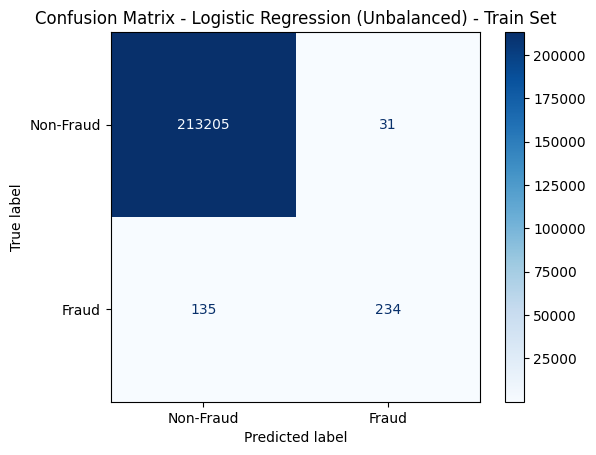

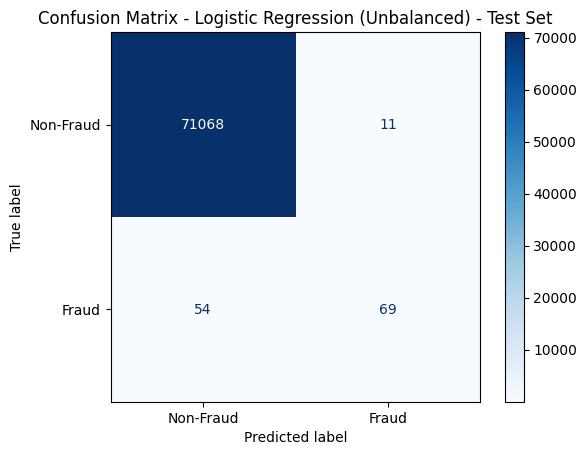

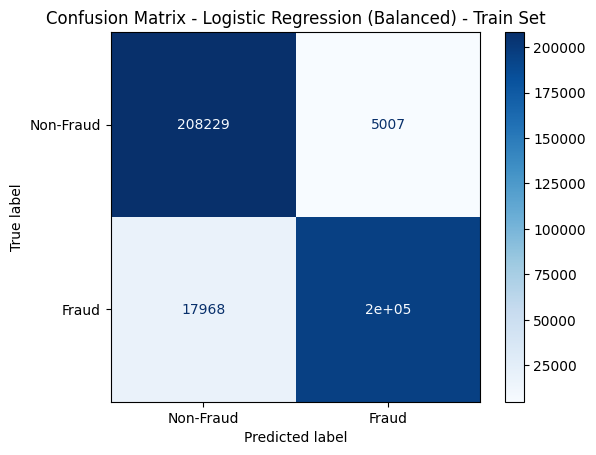

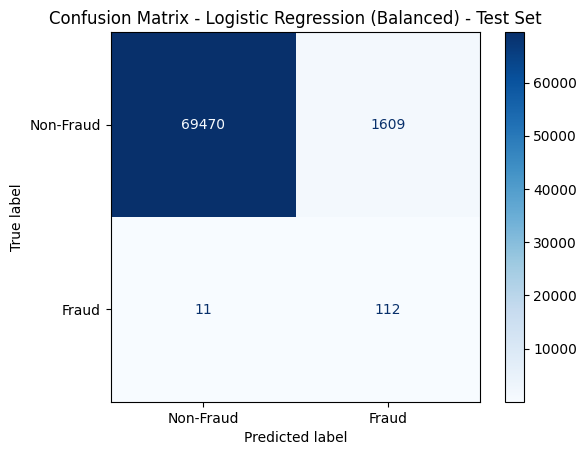

  Fold 2


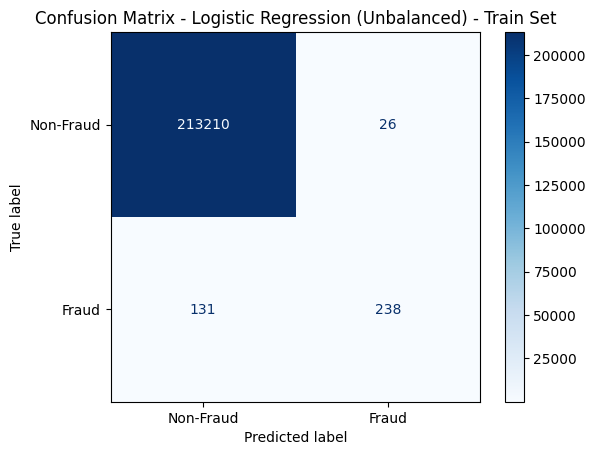

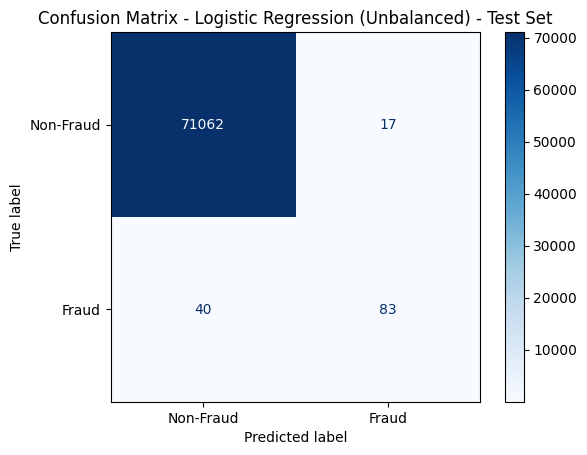

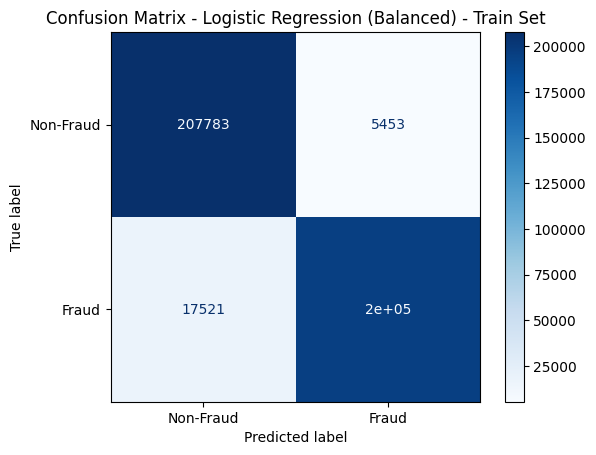

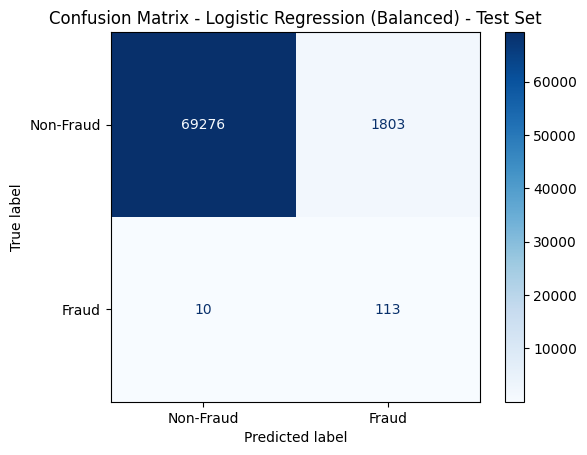

  Fold 3


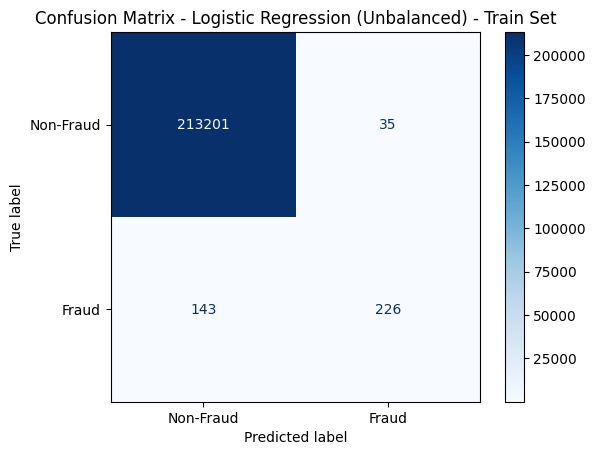

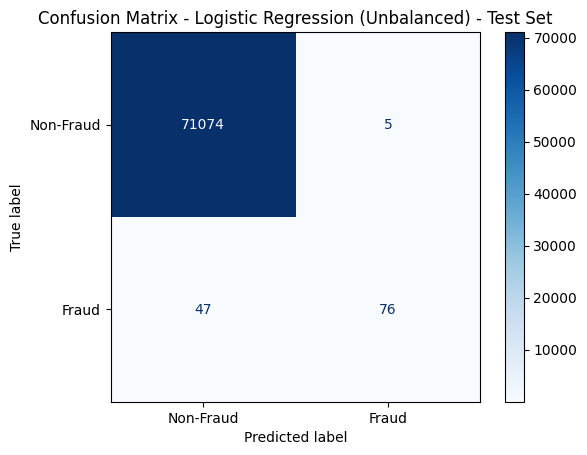

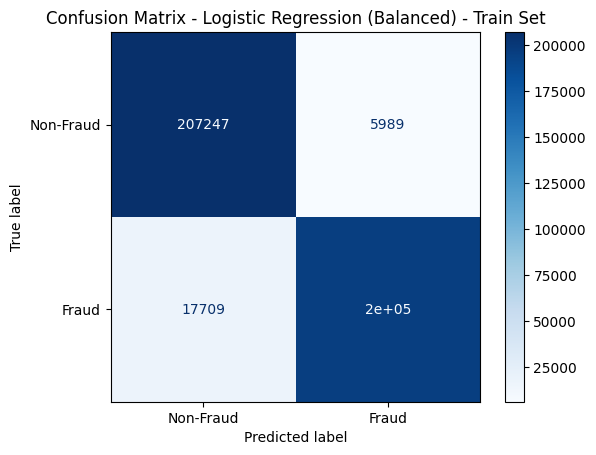

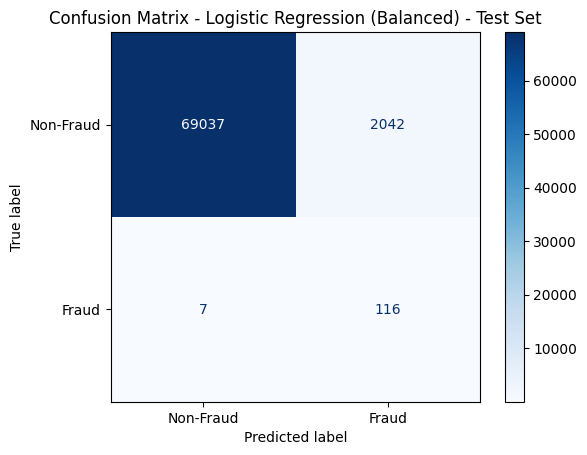

  Fold 4


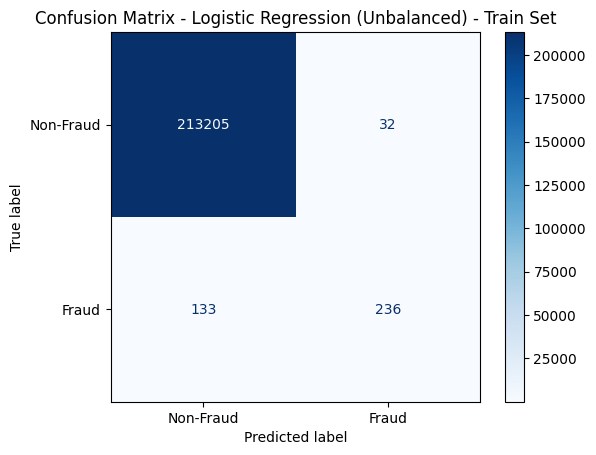

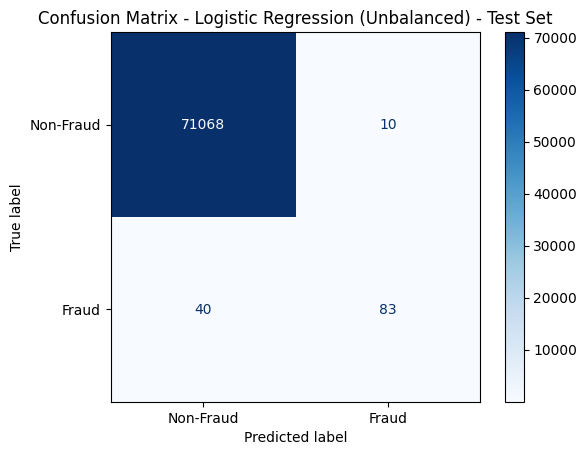

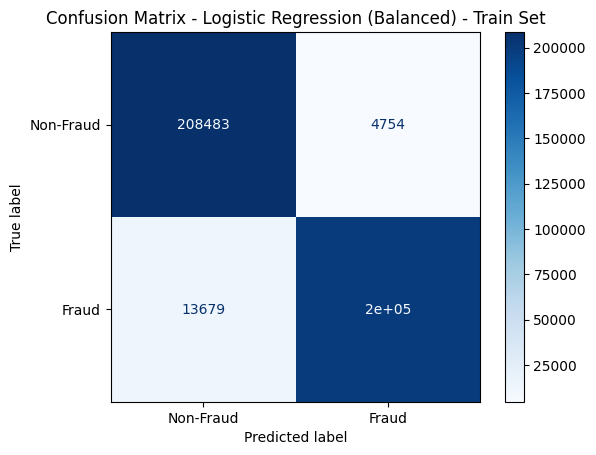

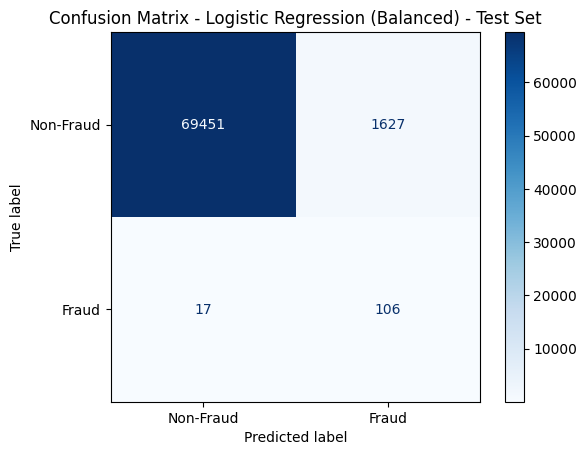

Evaluating model: Decision Tree
  Fold 1


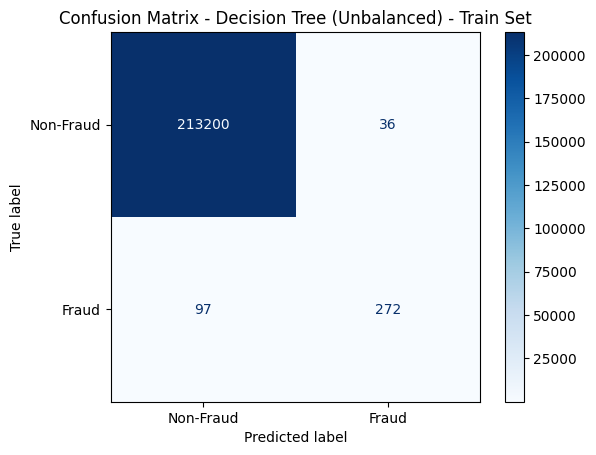

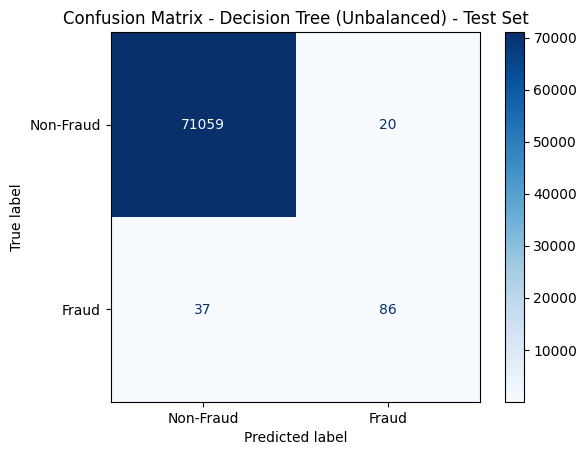

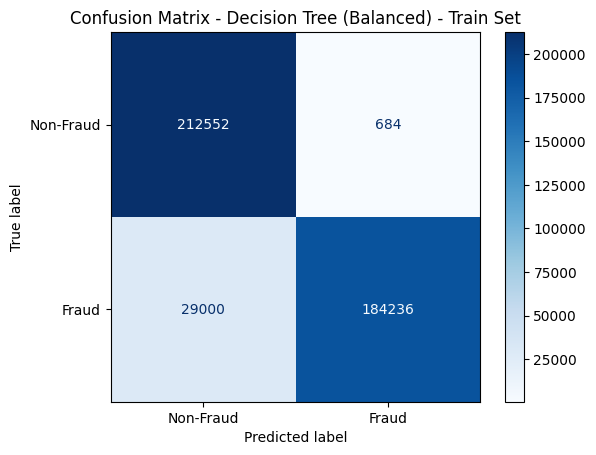

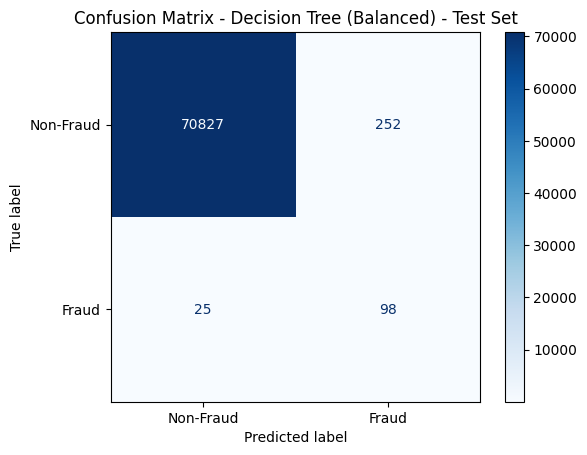

  Fold 2


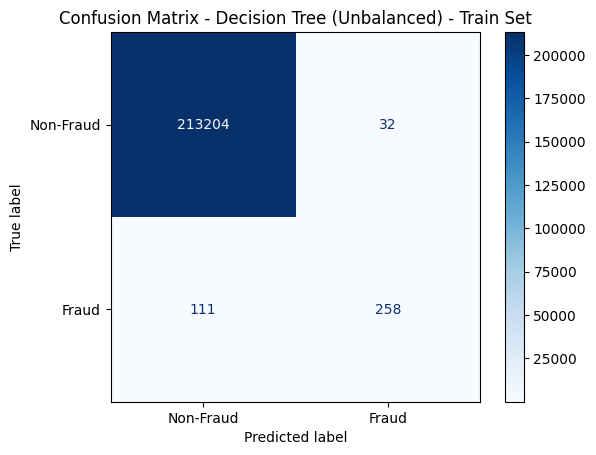

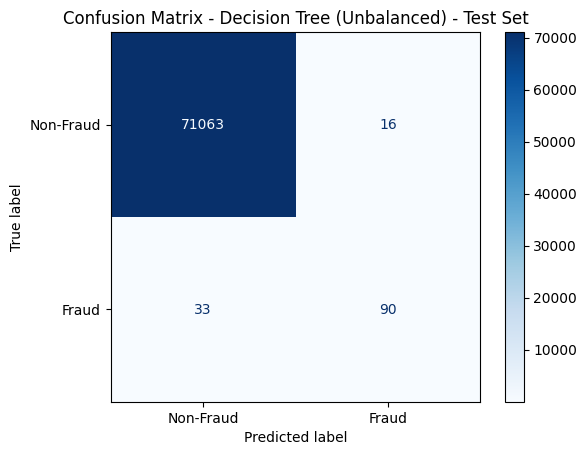

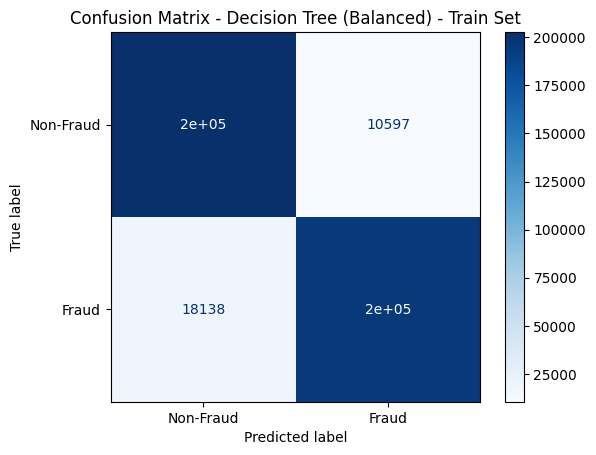

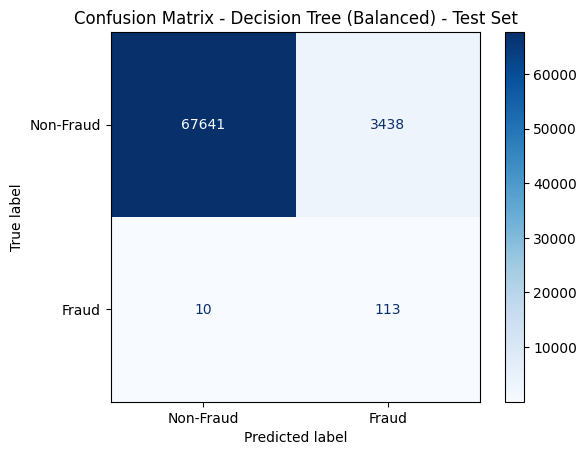

  Fold 3


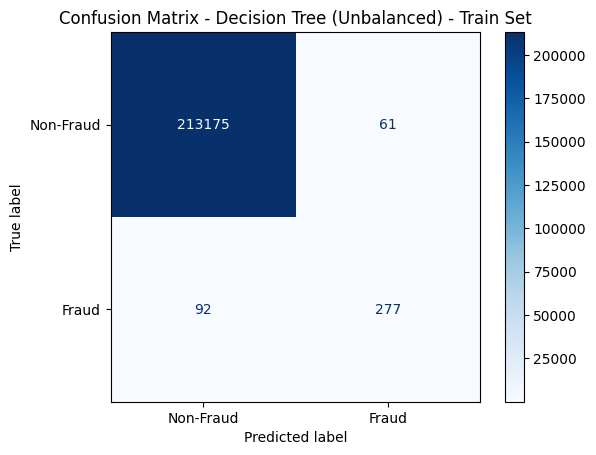

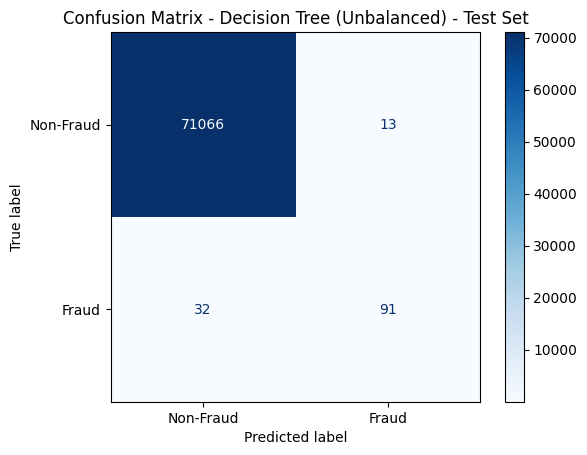

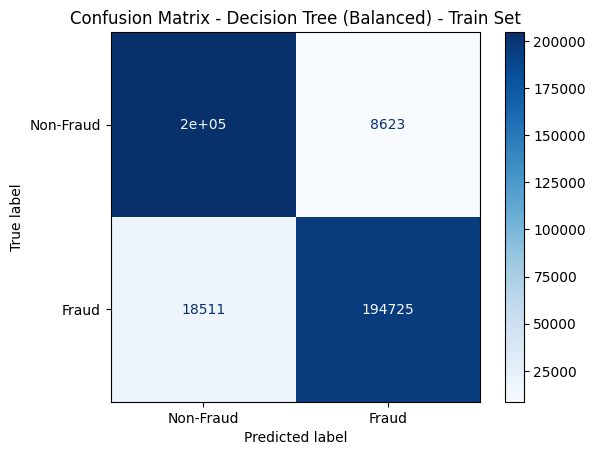

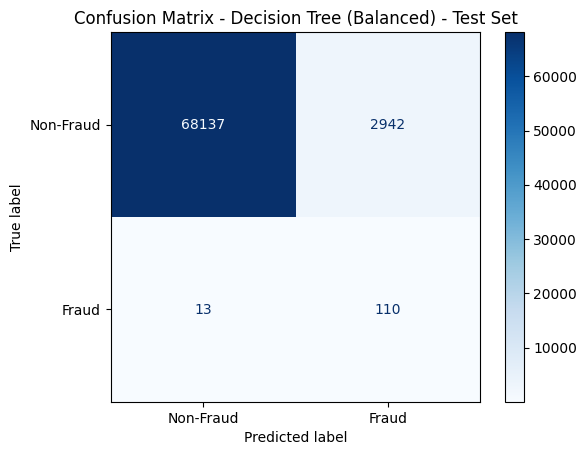

  Fold 4


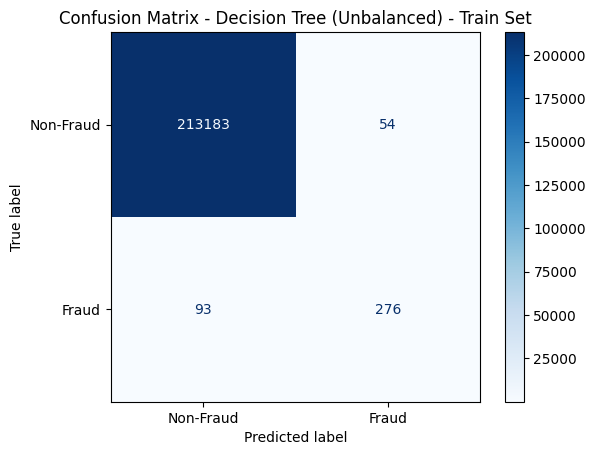

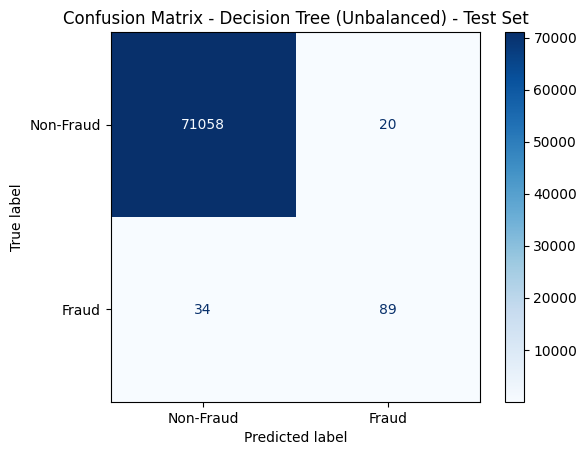

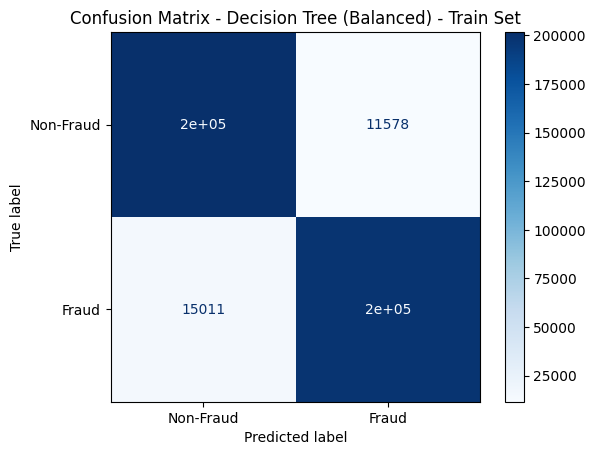

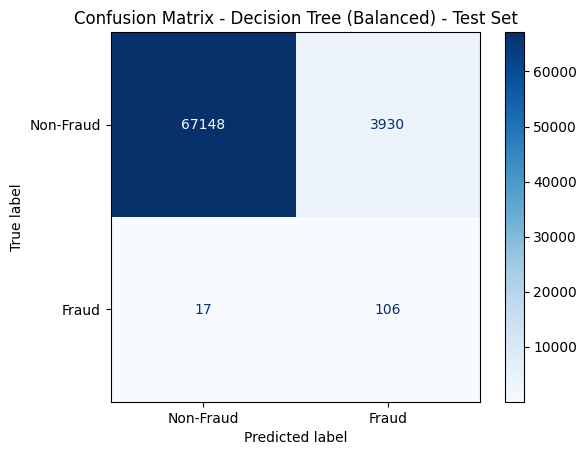

Evaluating model: Naive Bayes
  Fold 1


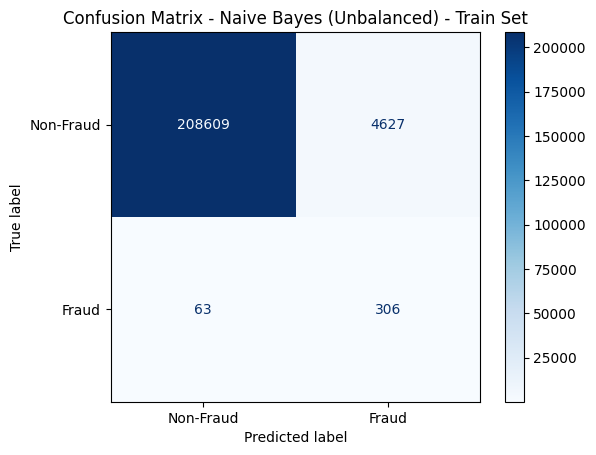

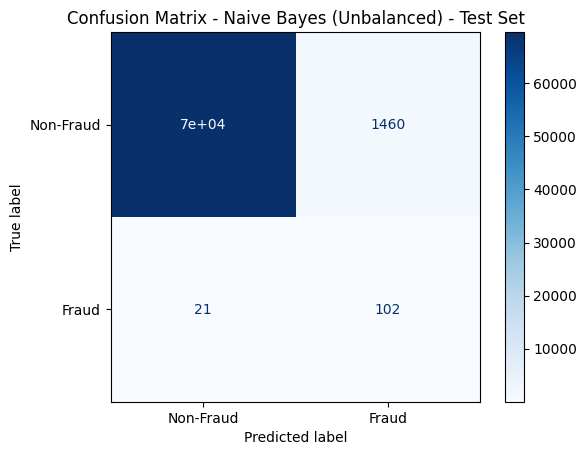

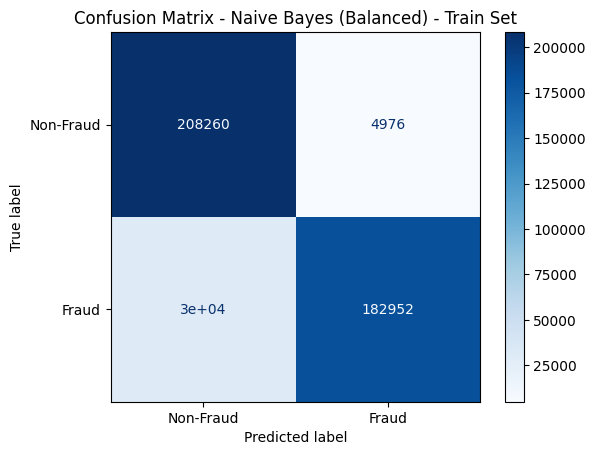

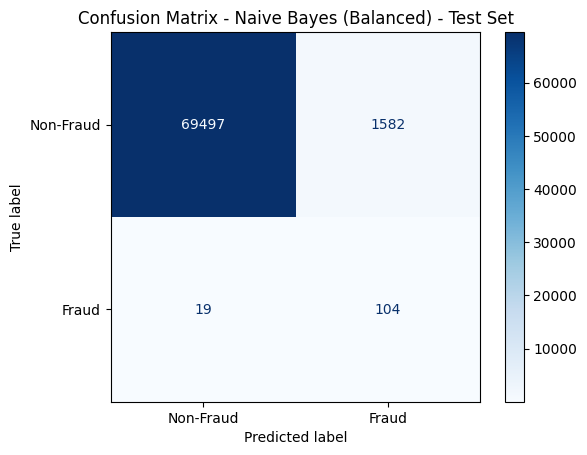

  Fold 2


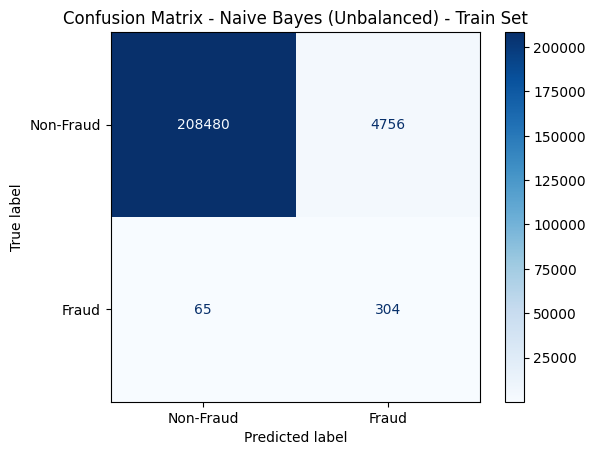

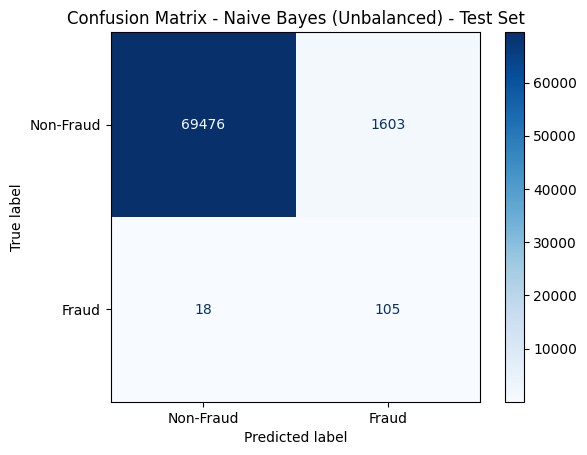

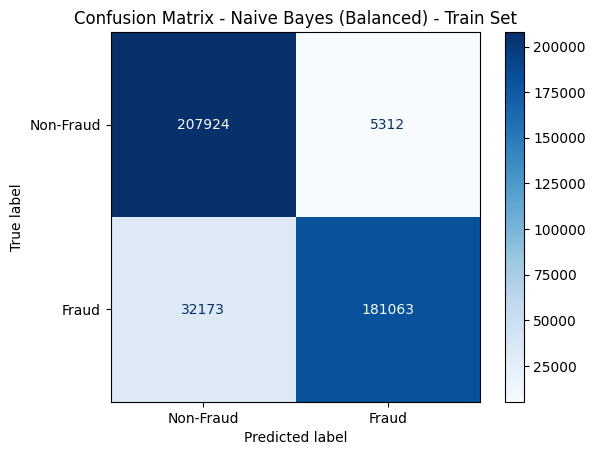

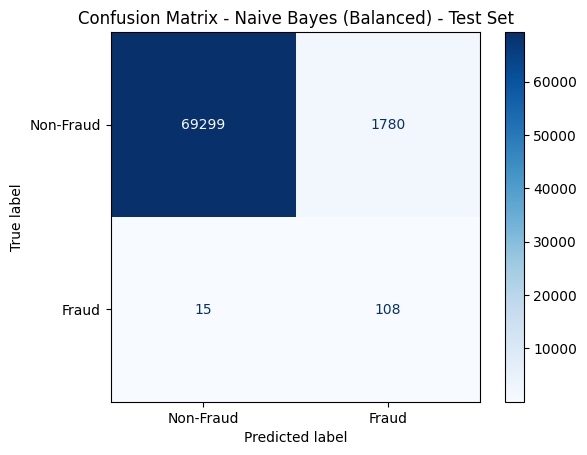

  Fold 3


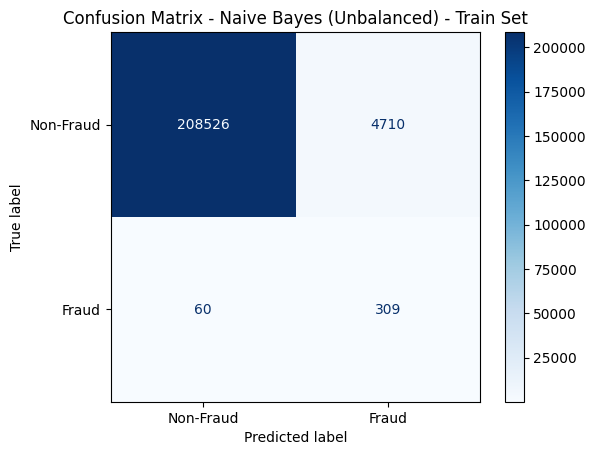

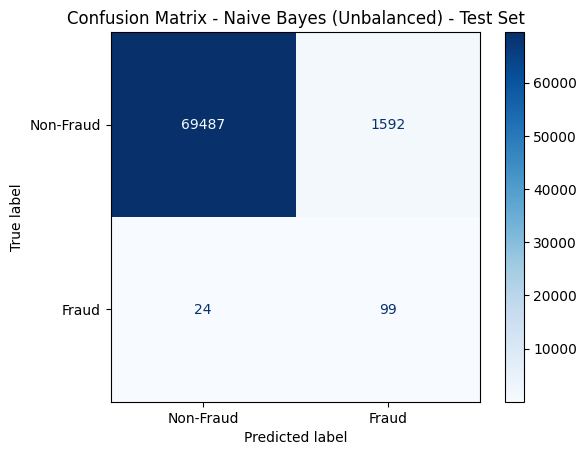

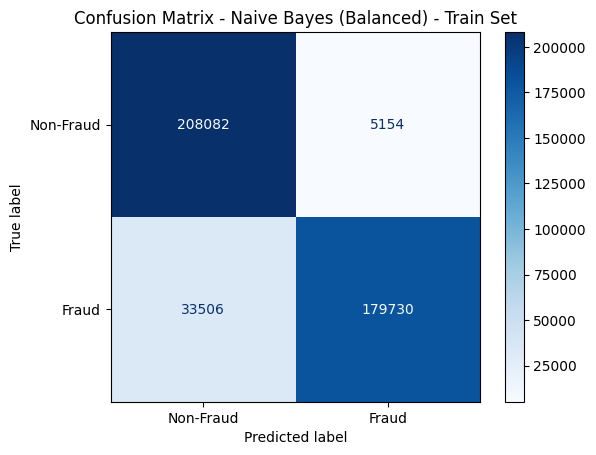

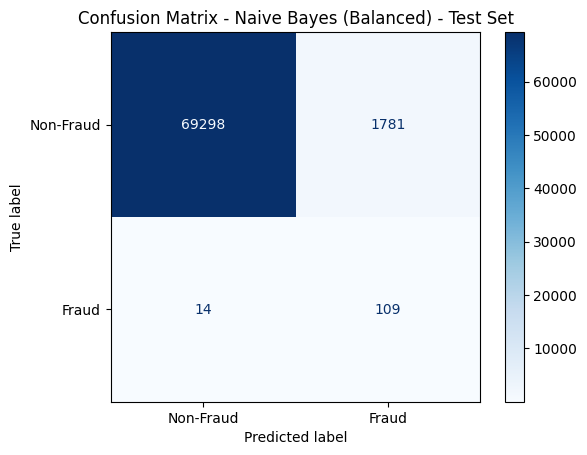

  Fold 4


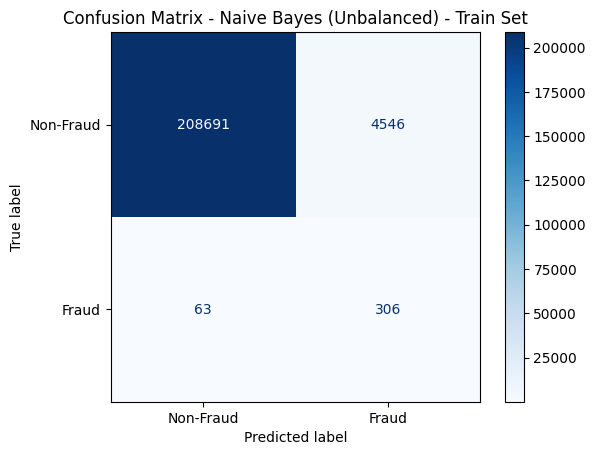

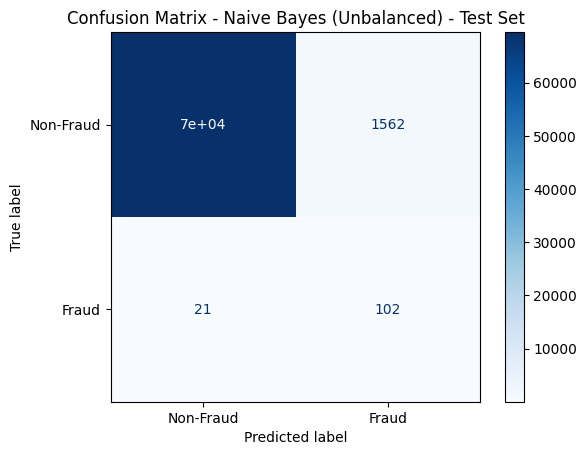

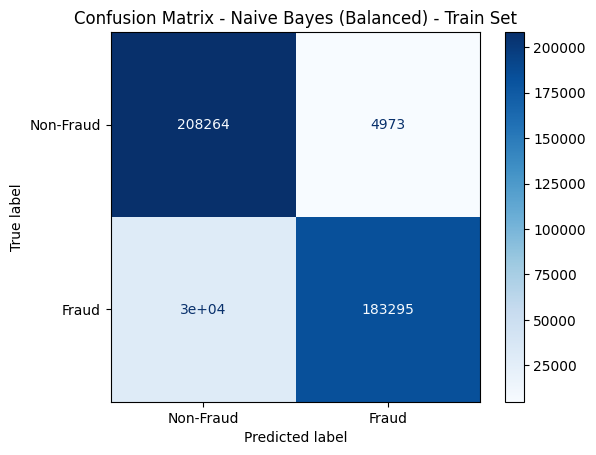

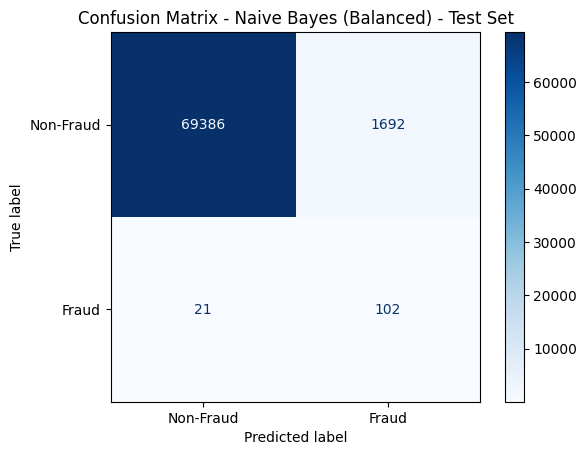

Evaluating model: XGBoost
  Fold 1


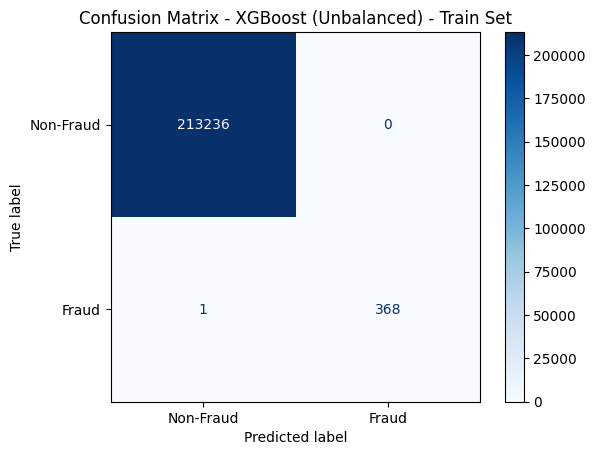

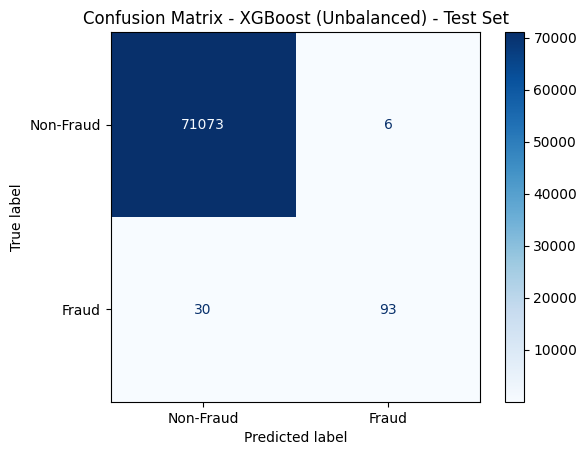

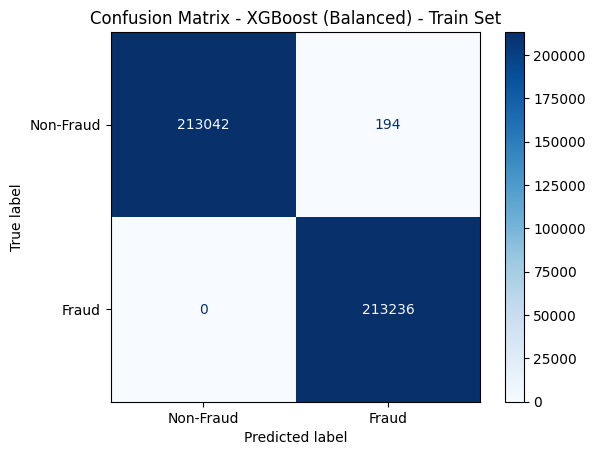

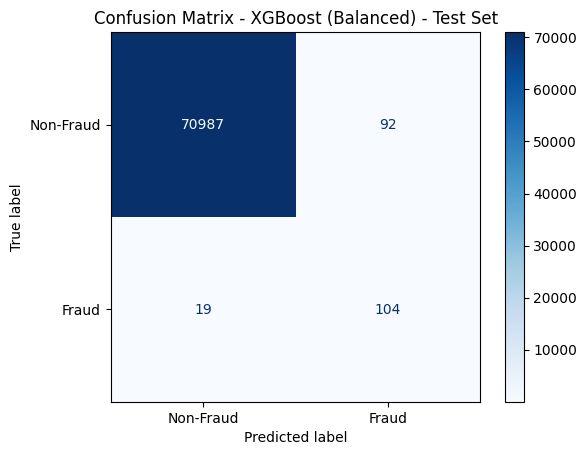

  Fold 2


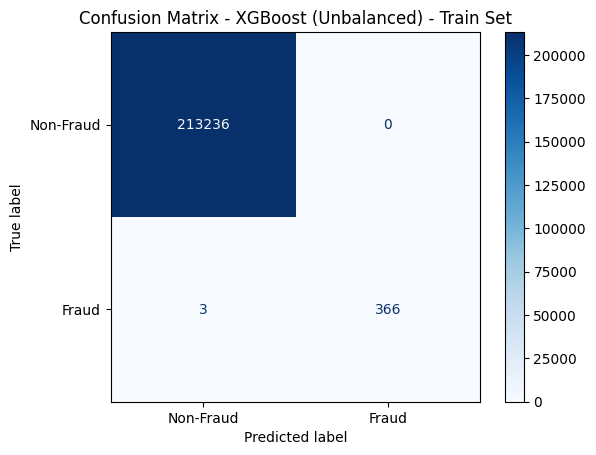

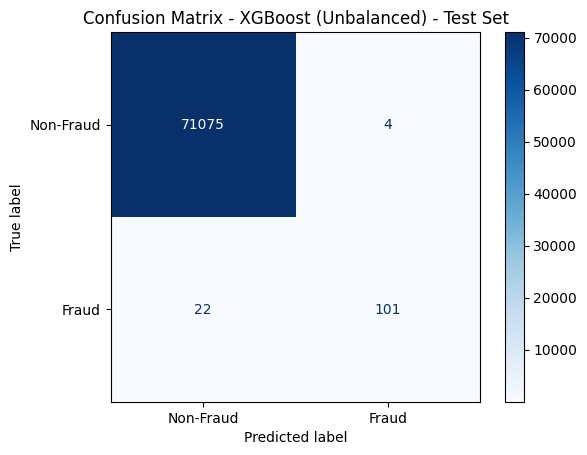

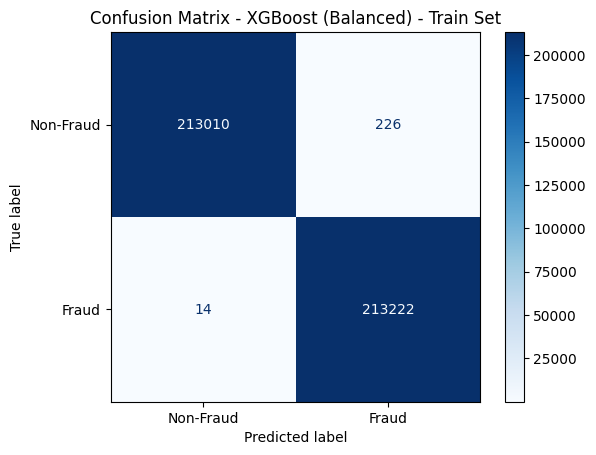

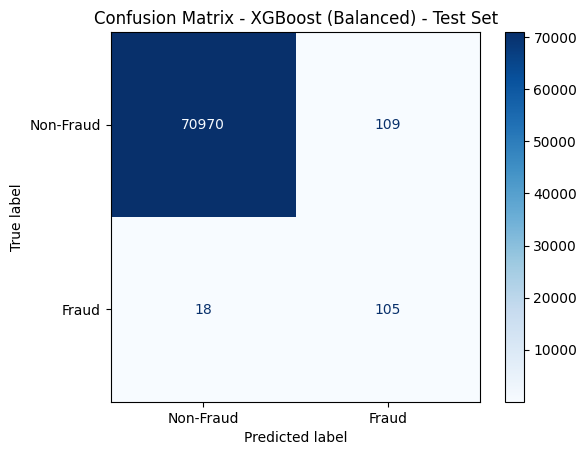

  Fold 3


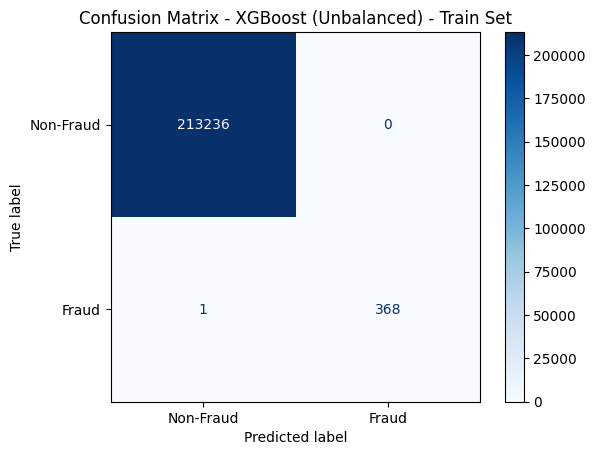

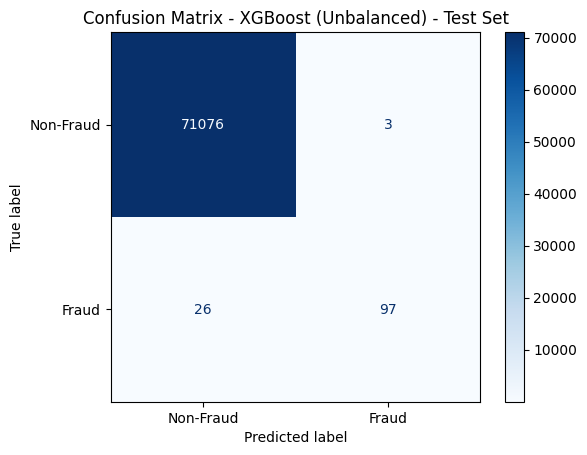

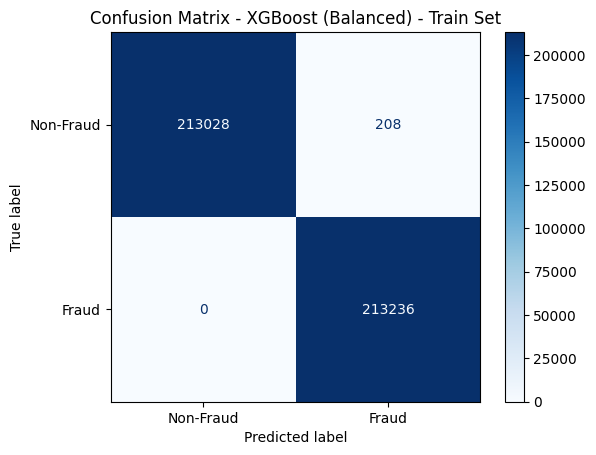

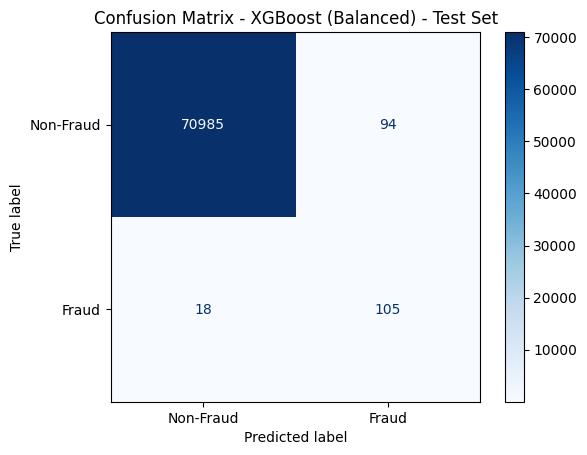

  Fold 4


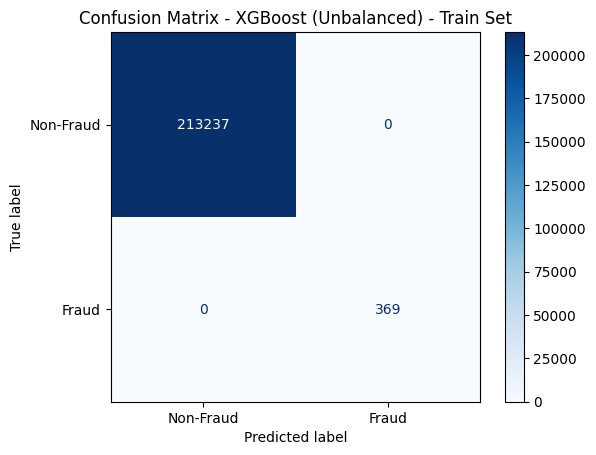

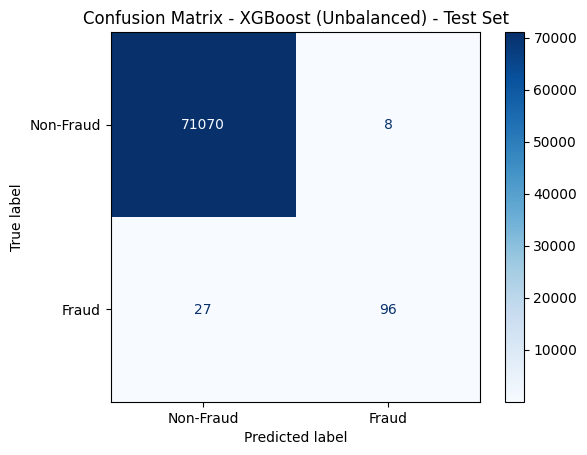

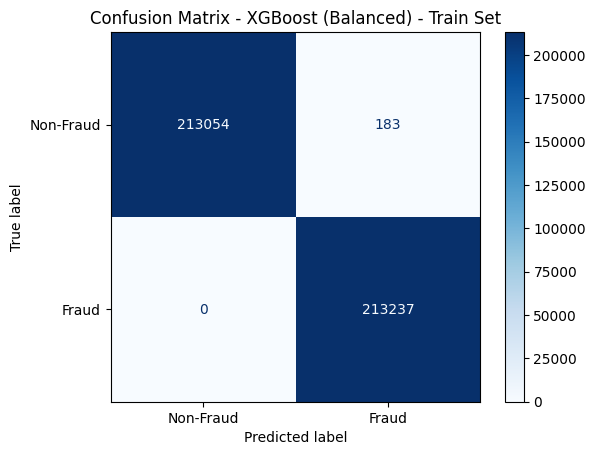

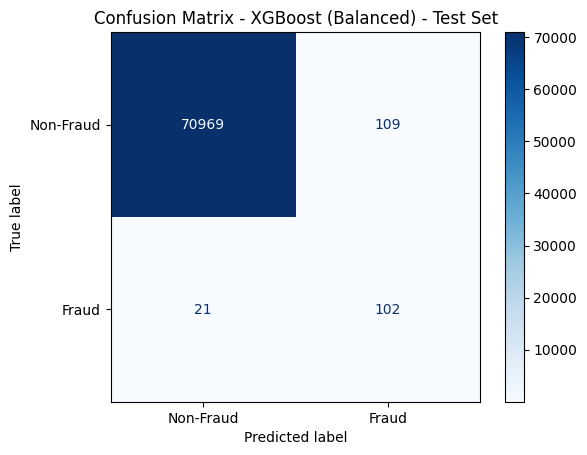

In [ ]:

# Loop through models first
for model_name, model in models.items():
    print(f"Evaluating model: {model_name}")

    # Loop through folds for the current model
    for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
        print(f"  Fold {fold + 1}")

        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        # Balance the training fold using SMOTE
        sm = SMOTE(random_state=42)
        X_train_fold_balanced, y_train_fold_balanced = sm.fit_resample(X_train_fold, y_train_fold)

        # Evaluate on both unbalanced and balanced training sets
        for balanced_type in ["Unbalanced", "Balanced"]:  # Added loop
            X_train_eval = X_train_fold if balanced_type == "Unbalanced" else X_train_fold_balanced
            y_train_eval = y_train_fold if balanced_type == "Unbalanced" else y_train_fold_balanced

            evaluate_model(model_name, model, X_train_eval, X_test_fold,
                            y_train_eval, y_test_fold, balanced=balanced_type, fold_num=fold + 1)

In [ ]:
# Save the results to a CSV file
results_df.to_csv("balancedDataOutcomes.csv", index=False)
print("Results saved to balancedDataOutcomes.csv")

Results saved to balancedDataOutcomes.csv


The following Code is for hyperparameter optimization. You dont have to run this part of the code

In [ ]:
# Create a smaller dataset (e.g., 10% of the original)
sample_fraction=0.1
df_sampled = df.sample(frac=sample_fraction, random_state=42)  # Use a random state for reproducibility

# Update X and y with the sampled data
X_sampled = df_sampled.drop(columns=['Class'])
y_sampled = df_sampled['Class']

# ... (Rest of your code using X_sampled and y_sampled for initial experiments) ...

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter search spaces for each model
param_dists = {
    "Logistic Regression": {
        'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']  # Choose appropriate solvers
    },
    "Decision Tree": {
        'max_depth': [3, 5, 7, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "Naive Bayes": {
        # Usually has few hyperparameters to tune
        'var_smoothing': [1e-9, 1e-8, 1e-7]
    },
    "XGBoost": {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
    },
    "Neural Network": {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01]
    },
    "Adaboost": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1.0],
        'algorithm': ['SAMME', 'SAMME.R']
    },
    "Random Forest": {  # Already defined earlier
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "Gradient Boosting": {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
    }
}


for model_name, model in models.items():
    print(f"Optimizing hyperparameters for {model_name}")

    # Get the hyperparameter search space for the current model
    param_dist = param_dists[model_name]

    if model_name in ["Logistic Regression", "Decision Tree", "Naive Bayes", "Adaboost"]:
        # Use GridSearchCV with param_dist instead of param_grid
        grid_search = GridSearchCV(model, param_grid=param_dist, cv=skf, scoring='f1', n_jobs=-1)
        grid_search.fit(X_sampled, y_sampled)
        best_params = grid_search.best_params_
    else:
        # Use RandomizedSearchCV
        random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=50, cv=skf, scoring='f1', n_jobs=-1, random_state=42)
        random_search.fit(X_sampled, y_sampled)
        best_params = random_search.best_params_

    print(f"  Best hyperparameters: {best_params}")


Optimizing hyperparameters for Logistic Regression
  Best hyperparameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Optimizing hyperparameters for Decision Tree
  Best hyperparameters: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}
Optimizing hyperparameters for Naive Bayes
  Best hyperparameters: {'var_smoothing': 1e-09}
Optimizing hyperparameters for XGBoost
  Best hyperparameters: {'subsample': 0.9, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2}
Optimizing hyperparameters for Neural Network


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 18 is smaller than n_iter=50. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


  Best hyperparameters: {'hidden_layer_sizes': (50, 50), 'alpha': 0.001, 'activation': 'tanh'}
Optimizing hyperparameters for Adaboost
  Best hyperparameters: {'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 200}
Optimizing hyperparameters for Random Forest
  Best hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 15}
Optimizing hyperparameters for Gradient Boosting


KeyboardInterrupt: 